In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv("xray_input.csv")
df.head()


,Image Index,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,-0.187979,0.043346,-0.005866,-0.180116,-0.216491,0.181554,0.053038,-0.242247,-0.196432,...,0,0,0,0,0,0,1,0,0,0
1,00000001_001.png,-0.173904,0.104313,-0.027356,0.061408,-0.213318,0.297480,0.328217,-0.221172,-0.119333,...,0,1,0,0,0,0,1,0,0,0
2,00000001_002.png,-0.156875,0.002193,-0.183765,0.010118,-0.242131,0.274381,-0.061397,0.085868,-0.178546,...,0,0,0,1,0,0,1,0,0,0
3,00000002_000.png,-0.197439,0.289834,-0.143378,0.238400,-0.159914,0.132197,-0.086083,-0.187805,-0.050839,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,-0.123684,-0.005224,-0.083841,0.031354,-0.202258,0.914344,0.074426,-0.222060,-0.199442,...,0,0,0,0,0,0,0,0,0,1


In [3]:
# Separate features and labels
X = df.filter(regex='^x\d+')
y = df[["Atelectasis", "Consolidation", "Infiltration", "Pneumothorax", "Edema",
       "Emphysema", "Fibrosis", "Effusion", "Pneumonia", "Pleural_Thickening",
       "Cardiomegaly", "Nodule", "Mass", "Hernia"]]

# Create a column indicating if all labels are 0 (no findings)
y['no_finding'] = (y.sum(axis=1) == 0).astype(int)

# Split the data first to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y.drop('no_finding', axis=1), 
    test_size=0.2, 
    random_state=42, 
    stratify=y['no_finding']
)

# Scale the data before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA - try reducing to ~100-200 components to start
# You can adjust n_components based on your RAM constraints and the variance explained
n_components = 150  # Starting point, adjust as needed
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check explained variance to ensure we've captured enough information
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total explained variance with {n_components} components: {explained_variance:.4f}")


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/5q/fmks3y_x73d1rdwpr7g2y9c40000gn/T/ipykernel_67939/599519454.py:2: SyntaxWarning: invalid escape sequence '\d'
  X = df.filter(regex='^x\d+')
/var/folders/5q/fmks3y_x73d1rdwpr7g2y9c40000gn/T/ipykernel_67939/599519454.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['no_finding'] = (y.sum(axis=1) == 0).astype(int)


Total explained variance with 150 components: 0.8418


Text(0.5, 1.0, 'Explained Variance vs. Number of Components')

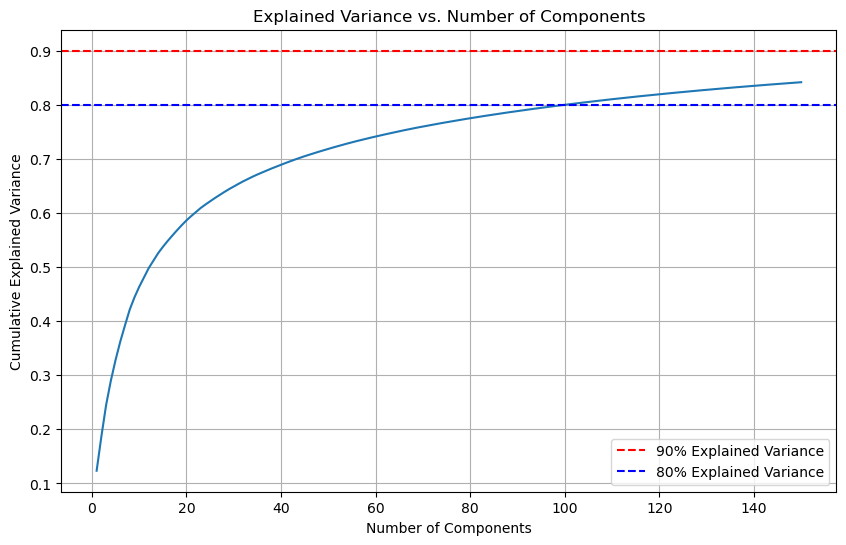

In [6]:
import matplotlib.pyplot as plt

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
plt.axhline(y=0.8, color='b', linestyle='--', label='80% Explained Variance')

plt.grid(True)
plt.legend()
plt.title('Explained Variance vs. Number of Components')
# plt.savefig('pca_variance.png')  # Save if in a headless environment